In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchvision
import dataloader2
import os
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
from collections import defaultdict
import numpy as np

In [2]:
# create dataset (adobe)
N_EPOCHS = 25

In [3]:
class faketruedataset(torch.utils.data.Dataset):
    
    def __init__(self, transformer=None):
        self.basedir = 'output_data/Adobe'
        self.real_ds = dataloader2.adobe240_dataset()
        self.fake_fps = os.listdir(self.basedir)
        self.transformer=transformer
    
    def __len__(self):
        return len(self.real_ds) + len(self.fake_fps)
    
    def __getitem__(self, idx):
        if idx < len(self.real_ds):
            img, label = self.real_ds[idx][0][0], 1
        else:
            i = idx-len(self.real_ds)
            fp = os.path.join(self.basedir, self.fake_fps[i])
            img = imageio.imread(fp)
            img = torch.Tensor(img)
            
            img, label = img, 0
            
        if self.transformer != None:
            img = self.transformer.apply_tensor(img).squeeze(dim=0)
            
        return img, label
        
        
    

In [4]:
transformer = dataloader2.Transformer(crop_size=(512,512))
ds = faketruedataset(transformer=transformer)
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

In [31]:
for x, y in dl:
    print(y)

tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 1, 1, 0, 1, 0, 1, 1])


KeyboardInterrupt: 

(<matplotlib.image.AxesImage at 0x2441ec41748>, tensor([0.], device='cuda:0'))

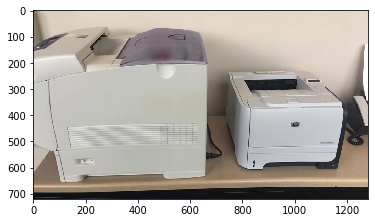

In [17]:
plt.imshow(X[4].detach().cpu().permute(1,2,0).int()), y[4]

In [6]:
N_train = int(len(ds) * 0.8)
N_test = len(ds)-N_train

train, test = torch.utils.data.random_split(ds, [N_train, N_test])

In [12]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.nnet = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.lin1 = nn.Linear(2048, 64)
        self.lin2 = nn.Linear(64, 1)
    
    def forward(self, x):
        conv_out = self.nnet(x)
        conv_out = conv_out.view(conv_out.size(0), -1)
#         print(conv_out.size())
        out = self.lin1(conv_out).relu()
        out = self.lin2(out)
        
        return out
        
    


In [40]:
## acuracy

In [13]:
# init model
model = Model().cuda()


optimizer = torch.optim.Adam(model.parameters())
critereon = torch.nn.BCEWithLogitsLoss()

In [14]:
m1 = list(model.parameters())
m1[0][0]

tensor([[[-0.1050,  0.0620,  0.0098],
         [ 0.0200, -0.0048,  0.0401],
         [ 0.0316, -0.0382,  0.1467]],

        [[ 0.1791,  0.0725,  0.0481],
         [ 0.0836, -0.1328, -0.0829],
         [ 0.0149, -0.0978, -0.1351]],

        [[-0.0999, -0.1632, -0.0956],
         [-0.0652,  0.0586,  0.0171],
         [ 0.0918,  0.1881, -0.1301]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [15]:
m2 = list(model.parameters())
m2[0][0]

tensor([[[-0.1050,  0.0620,  0.0098],
         [ 0.0200, -0.0048,  0.0401],
         [ 0.0316, -0.0382,  0.1467]],

        [[ 0.1791,  0.0725,  0.0481],
         [ 0.0836, -0.1328, -0.0829],
         [ 0.0149, -0.0978, -0.1351]],

        [[-0.0999, -0.1632, -0.0956],
         [-0.0652,  0.0586,  0.0171],
         [ 0.0918,  0.1881, -0.1301]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [16]:
train_dl = DataLoader(train, batch_size=16, shuffle=True)
test_dl = DataLoader(test, batch_size=16)

train_acc = defaultdict(list)
valid_acc = defaultdict(list)

def accuracy(y_true, y_hat):
    return (y_true == y_hat.round()).float().mean().item()

for epoch in range(N_EPOCHS):
    for i, (X, y) in tqdm(enumerate(train_dl), total=len(train_dl), desc=f'Epoch {epoch+1}/{N_EPOCHS}'):
        X = X.cuda().permute(0,3,1,2)
        y = y.cuda().unsqueeze(1).float()
        y_hat = model(X)
        loss = critereon(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        acc = accuracy(y, y_hat.sigmoid())
        train_acc[epoch].append(acc)
      
    
    for i, (X, y) in enumerate(test_dl):
        X = X.cuda().permute(0,3,1,2)
        y = y.cuda().unsqueeze(1).float()
        y_hat = model(X)
        loss = critereon(y, y_hat)
        
        acc = accuracy(y, y_hat.sigmoid())
        valid_acc[epoch].append(acc)
       
    print(f'train acc: {np.mean(train_acc[epoch])}, valid acc: {np.mean(valid_acc[epoch])}')
        
        
        
    

Epoch 1/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:59<00:00,  1.70it/s]


train acc: 0.46161048700300494, valid acc: 0.46467391304347827


Epoch 2/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:59<00:00,  1.45it/s]


train acc: 0.5095973785003919, valid acc: 0.46467391304347827


Epoch 3/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:01<00:00,  1.55it/s]


train acc: 0.5161516853932584, valid acc: 0.47554347826086957


Epoch 4/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.58it/s]


train acc: 0.5023408244165142, valid acc: 0.46467391304347827


Epoch 5/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.52it/s]


train acc: 0.4882958802614319, valid acc: 0.46467391304347827


Epoch 6/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.57it/s]


train acc: 0.5095973785003919, valid acc: 0.46467391304347827


Epoch 7/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.59it/s]


train acc: 0.4990636706352234, valid acc: 0.532608695652174


Epoch 8/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.50it/s]


train acc: 0.49765917625320094, valid acc: 0.4782608695652174


Epoch 9/25: 100%|██████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.49it/s]


train acc: 0.5173220976015155, valid acc: 0.46467391304347827


Epoch 10/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.48it/s]


train acc: 0.5086610491356153, valid acc: 0.48097826086956524


Epoch 11/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [01:01<00:00,  1.63it/s]


train acc: 0.48384831460674155, valid acc: 0.5217391304347826


Epoch 12/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.72it/s]


train acc: 0.5170880154277502, valid acc: 0.5271739130434783


Epoch 13/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.67it/s]


train acc: 0.4978932584269663, valid acc: 0.5597826086956522


Epoch 14/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.70it/s]


train acc: 0.5046816481633133, valid acc: 0.5190217391304348


Epoch 15/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.68it/s]


train acc: 0.49204119872511104, valid acc: 0.5027173913043478


Epoch 16/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:59<00:00,  1.57it/s]


train acc: 0.4939138581243794, valid acc: 0.483695652173913


Epoch 17/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.67it/s]


train acc: 0.4939138577895218, valid acc: 0.44565217391304346


Epoch 18/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.62it/s]


train acc: 0.5145131088374706, valid acc: 0.5353260869565217


Epoch 19/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.75it/s]


train acc: 0.476123595505618, valid acc: 0.48097826086956524


Epoch 20/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:59<00:00,  1.58it/s]


train acc: 0.5070224719101124, valid acc: 0.46467391304347827


Epoch 21/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.59it/s]


train acc: 0.5072565547535929, valid acc: 0.46467391304347827


Epoch 22/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:58<00:00,  1.73it/s]


train acc: 0.506086142377907, valid acc: 0.46467391304347827


Epoch 23/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.67it/s]


train acc: 0.5065543072277241, valid acc: 0.46467391304347827


Epoch 24/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [00:57<00:00,  1.57it/s]


train acc: 0.506788389736347, valid acc: 0.46467391304347827


Epoch 25/25: 100%|█████████████████████████████████████████████████████████████████████| 89/89 [01:01<00:00,  1.48it/s]


train acc: 0.506788389736347, valid acc: 0.46467391304347827
